<a href="https://www.kaggle.com/code/ravaghi/visualizing-norwegian-review-corpus?scriptVersionId=165918117" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview
* [Loading and processing the dataset](#data-loading)
* [Analyzing review lengths](#review-lengths)
* [Taking a look at the distribution of ratings and labels](#label-distribution)
* [Sentiment over time](#sentiment-time)
* [Analyzing n-grams](#ngrams)

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from typing import List, Tuple
import matplotlib.pyplot as plt
from datetime import date
from typing import Dict, List
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import json
import re
import os

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Loading data <a class="anchor" id="data-loading"></a>
The dataset has a rating column featuring values ranging from 1 to 6, these are the actual review values given by the users. Given that the primary applications of this dataset typically involve binary or multiclass classification tasks, I intend to approach the analysis from two distinct perspectives. Firstly, I will generate a dataset with binary labels (0 or 1) denoting negative and positive sentiments, achieved by evenly splitting the ratings. Secondly, I will create another dataset featuring three labels (0, 1, and 2) representing negative, neutral, and positive sentiments, respectively. It's important to note that the split for the multiclass datasets is uneven, mirroring the strategy used by [NorBench](https://arxiv.org/abs/2305.03880) for the same dataset in their experiments. I will also take a look at the original ratings in some cases.

In [2]:
def load_and_process_data(binary: bool) -> pd.DataFrame:
    def _parse_rating(rating: int) -> int:
        if binary:
            if rating <= 3:
                return 0
            else:
                return 1
        else:
            if rating < 4:
                return 0
            elif rating == 4:
                return 1
            else:
                return 2
        
    dataset = pd.read_csv("/kaggle/input/norwegian-review-corpus/norec.csv", low_memory=False)
    dataset["label"] = dataset["rating"].apply(_parse_rating)

    dataset["date"] = dataset.apply(lambda x: date(x["year"], x["month"], x["day"]), axis=1)
    dataset = dataset[
        [
            'authors',
            'category',
            'excerpt',
            'language',
            'rating',
            'source',
            'source-category',
            'source-tags',
            'split',
            'tags',
            'title',
            'text',
            'label',
            'date'
        ]
    ]
    return dataset

In [3]:
binary_ds = load_and_process_data(True)
multiclass_ds = load_and_process_data(False)

In [4]:
BINARY_LABEL_TO_ID_MAPPING = {
    "positive": 1,
    "negative": 0
}
BINARY_ID_TO_LABEL_MAPPING = {
    1: "positive",
    0: "negative"
}
MULTICLASS_LABEL_TO_ID_MAPPING = {
    "positive": 2,
    "neutral": 1,
    "negative": 0
}
MULTICLASS_ID_TO_LABEL_MAPPING = {
    2: "positive",
    1: "neutral",
    0: "negative"
}

POSITIVE_COLOR = "#20C997"
NEUTRAL_COLOR = "#FF9A00"
NEGATIVE_COLOR = "#E83E8C"

BINARY_PALETTE = {0: NEGATIVE_COLOR, 1: POSITIVE_COLOR}
MULTICLASS_PALETTE = {0: NEGATIVE_COLOR, 1: NEUTRAL_COLOR, 2: POSITIVE_COLOR}

# Review lengths <a class="anchor" id="review-lengths"></a>

In [5]:
def get_token_counts(dataset: pd.DataFrame) -> Dict:
    token_counts = {}
    for _, row in dataset.iterrows():
        token_count = len(row["text"].split(" "))
        if row["label"] not in token_counts:
            token_counts[row["label"]] = [token_count]
        else:
            token_counts[row["label"]].append(token_count)
    return token_counts

In [6]:
binary_ds_token_counts = get_token_counts(binary_ds)
multiclass_ds_token_counts = get_token_counts(multiclass_ds)

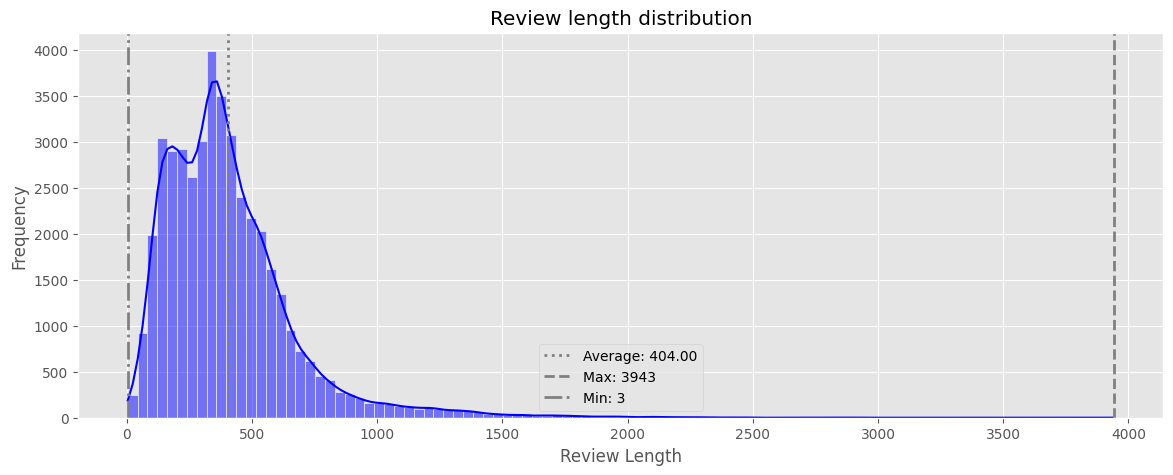

In [7]:
avg_length = int((sum(binary_ds_token_counts[0]) + sum(binary_ds_token_counts[1])) / (len(binary_ds_token_counts[1]) + len(binary_ds_token_counts[0])))
max_length = max(max(binary_ds_token_counts[0]), max(binary_ds_token_counts[1]))
min_length = min(min(binary_ds_token_counts[0]), min(binary_ds_token_counts[1]))

plt.figure(figsize=(14, 5))
sns.histplot(binary_ds_token_counts[0] + binary_ds_token_counts[1], kde=True, color="blue", bins=100)
plt.axvline(avg_length, color='grey', linestyle='dotted', linewidth=2, label=f'Average: {avg_length:.2f}')
plt.axvline(max_length, color='grey', linestyle='dashed', linewidth=2, label=f'Max: {max_length}')
plt.axvline(min_length, color='grey', linestyle='dashdot', linewidth=2, label=f'Min: {min_length}')
plt.title("Review length distribution")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

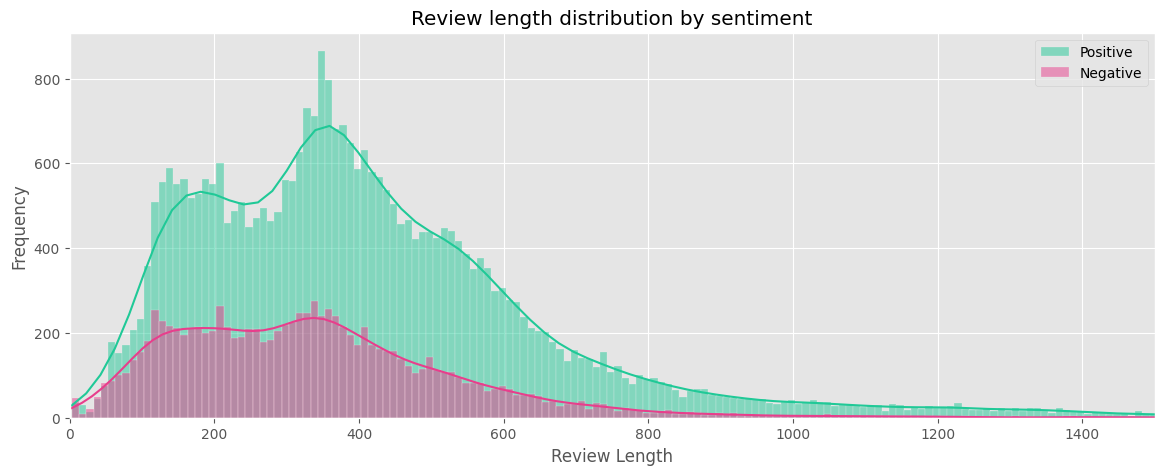

In [8]:
bin_width = 10
bins = range(
    min(min(binary_ds_token_counts[0]), min(binary_ds_token_counts[1])), 
    max(max(binary_ds_token_counts[0]), max(binary_ds_token_counts[1])) + bin_width, 
    bin_width
)

plt.figure(figsize=(14, 5))
sns.histplot(binary_ds_token_counts[1], kde=True, color=POSITIVE_COLOR, bins=bins, label="Positive")
sns.histplot(binary_ds_token_counts[0], kde=True, color=NEGATIVE_COLOR, bins=bins, label="Negative")
plt.xlim([0, 1500])
plt.title("Review length distribution by sentiment")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

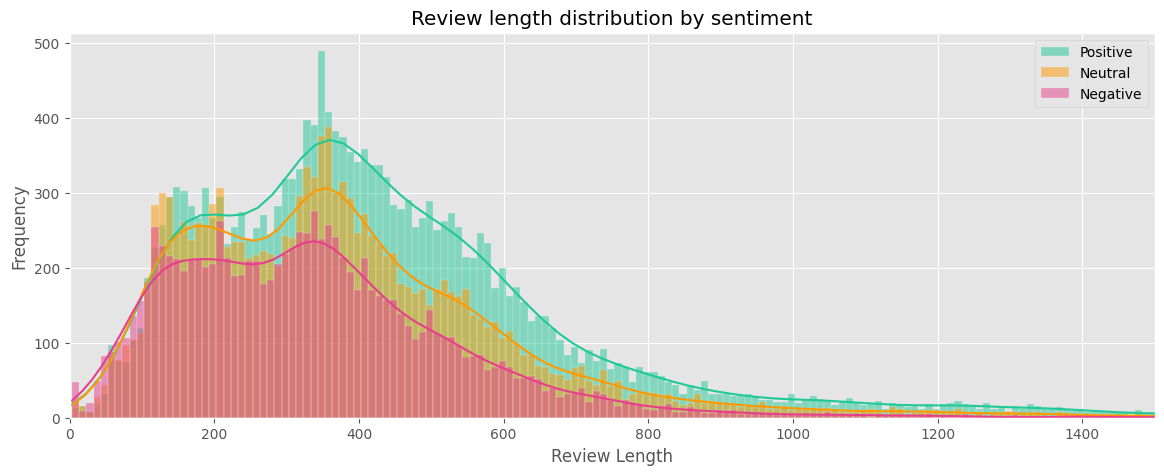

In [9]:
bin_width = 10
bins = range(
    min(min(multiclass_ds_token_counts[0]), min(multiclass_ds_token_counts[1]), min(multiclass_ds_token_counts[2])), 
    max(max(multiclass_ds_token_counts[0]), max(multiclass_ds_token_counts[1]), max(multiclass_ds_token_counts[2])) + bin_width,
    bin_width
)

plt.figure(figsize=(14, 5))
sns.histplot(multiclass_ds_token_counts[2], kde=True, color=POSITIVE_COLOR, bins=bins, label="Positive")
sns.histplot(multiclass_ds_token_counts[1], kde=True, color=NEUTRAL_COLOR, bins=bins, label="Neutral")
sns.histplot(multiclass_ds_token_counts[0], kde=True, color=NEGATIVE_COLOR, bins=bins, label="Negative")
plt.xlim([0, 1500])
plt.title("Review length distribution by sentiment")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Label distributions <a class="anchor" id="label-distribution"></a>

The dataset is hightly imbalanced no matter how the ratings are split. The plots below illustrate the distribution of sentiment samples in each split, along with the overall label distribution across the entire dataset. In both the binary and multiclass scenarios, positive sentiment dominates the reviews. Furthermore, the distibution of each label in each split seem to be even. 

## Original ratings

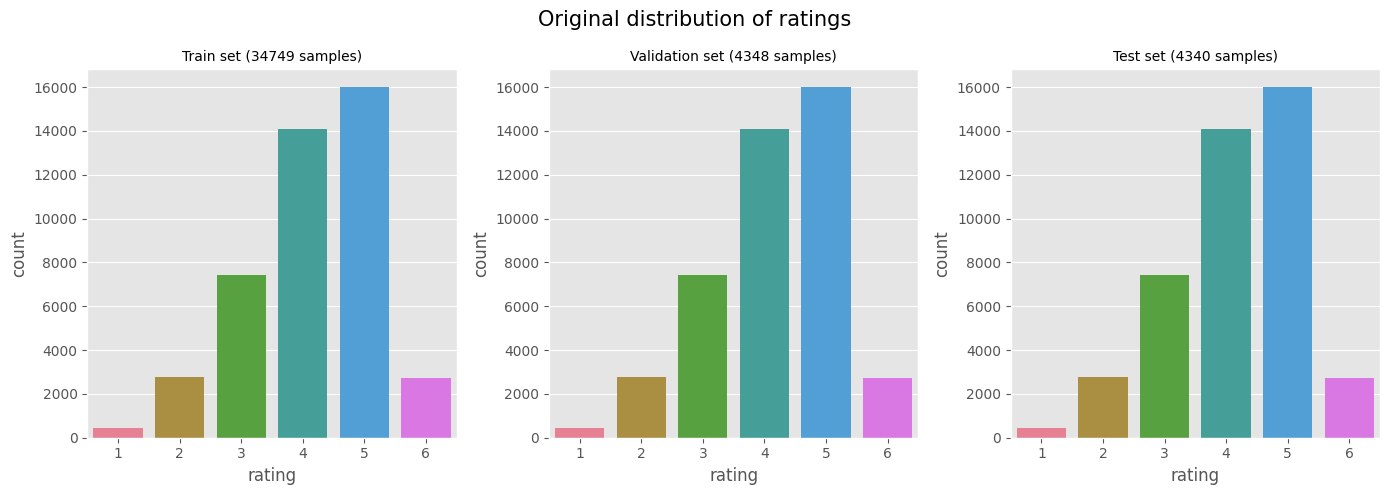

In [10]:
train_total = binary_ds[binary_ds["split"] == "train"].shape[0]
val_total = binary_ds[binary_ds["split"] == "dev"].shape[0]
test_total = binary_ds[binary_ds["split"] == "test"].shape[0]

fig, ax = plt.subplots(1, 3, figsize=(14, 5))
fig.suptitle("Original distribution of ratings", fontsize=15)
sns.countplot(x="rating", data=binary_ds, ax=ax[0], palette="husl")
sns.countplot(x="rating", data=binary_ds, ax=ax[1], palette="husl")
sns.countplot(x="rating", data=binary_ds, ax=ax[2], palette="husl")
ax[0].set_title(f"Train set ({train_total} samples)", fontsize=10)
ax[1].set_title(f"Validation set ({val_total} samples)", fontsize=10)
ax[2].set_title(f"Test set ({test_total} samples)", fontsize=10)

plt.tight_layout()
plt.show()

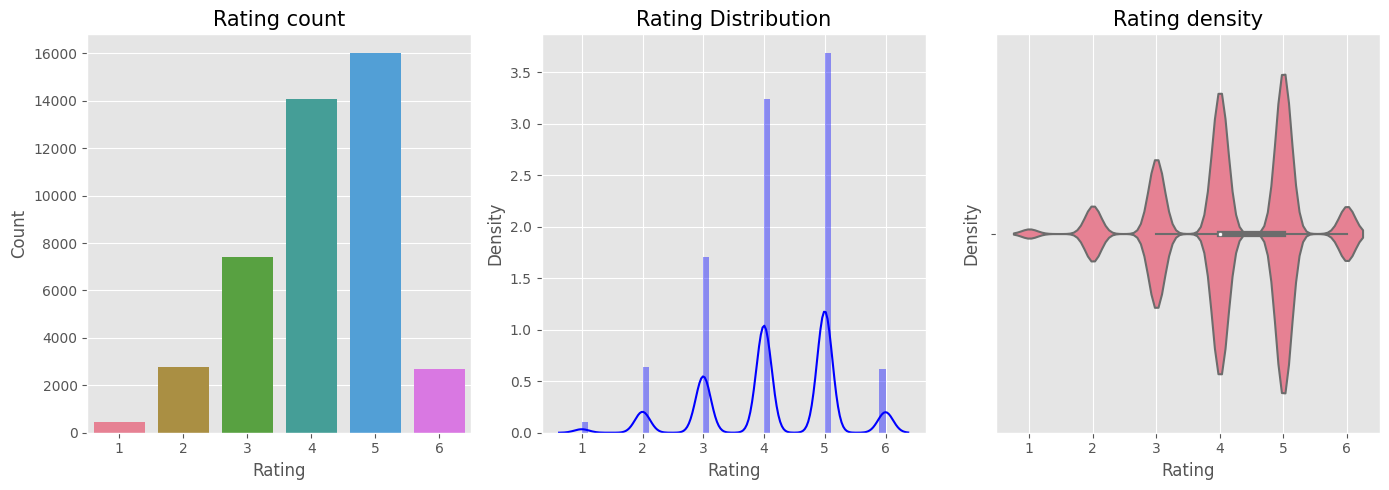

In [11]:
plt.figure(figsize=(14, 5))

ax1 = plt.subplot(131)
sns.countplot(x='rating', data=binary_ds, palette='husl', ax=ax1)
ax1.set_title('Rating count', fontsize=15)
ax1.set_xlabel('Rating', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)

ax2 = plt.subplot(132)
sns.distplot(binary_ds['rating'], color='blue', ax=ax2)
ax2.set_title('Rating Distribution', fontsize=15)
ax2.set_xlabel('Rating', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)

ax3 = plt.subplot(133)
sns.violinplot(x='rating', data=binary_ds, palette='husl', ax=ax3)
ax3.set_title('Rating density', fontsize=15)
ax3.set_xlabel('Rating', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)

plt.tight_layout()
plt.show()

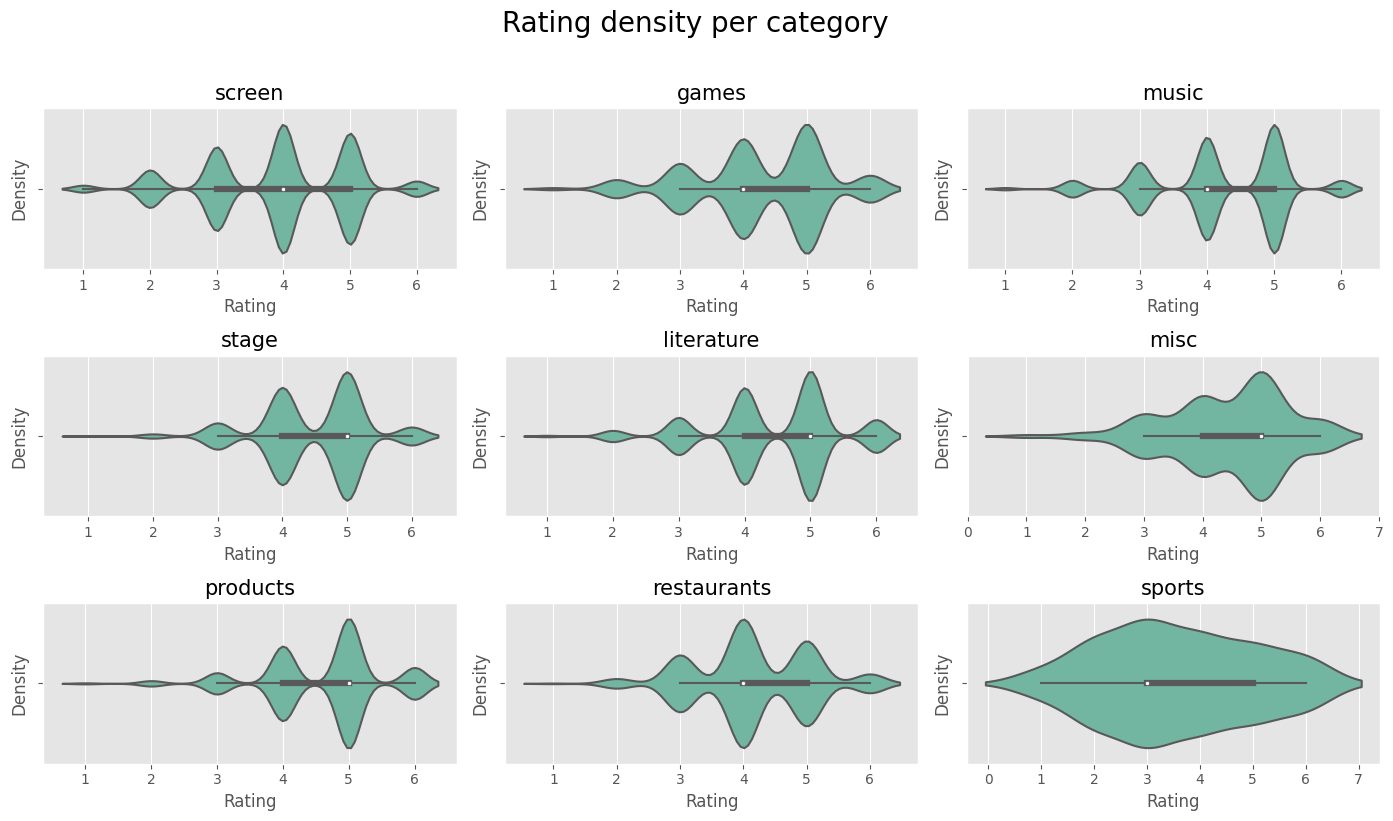

In [12]:
plt.figure(1, figsize=(14, 8))
n = 0
for category in binary_ds['category'].unique():
    n += 1
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    sns.violinplot(x='rating', data=binary_ds.where(binary_ds['category'] == category), palette='Set2')
    plt.title(category, fontsize=15)
    plt.xlabel('Rating', fontsize=12)
    plt.ylabel('Density', fontsize=12)

plt.suptitle('Rating density per category', fontsize=20, y=1.02)    
plt.tight_layout()
plt.show()

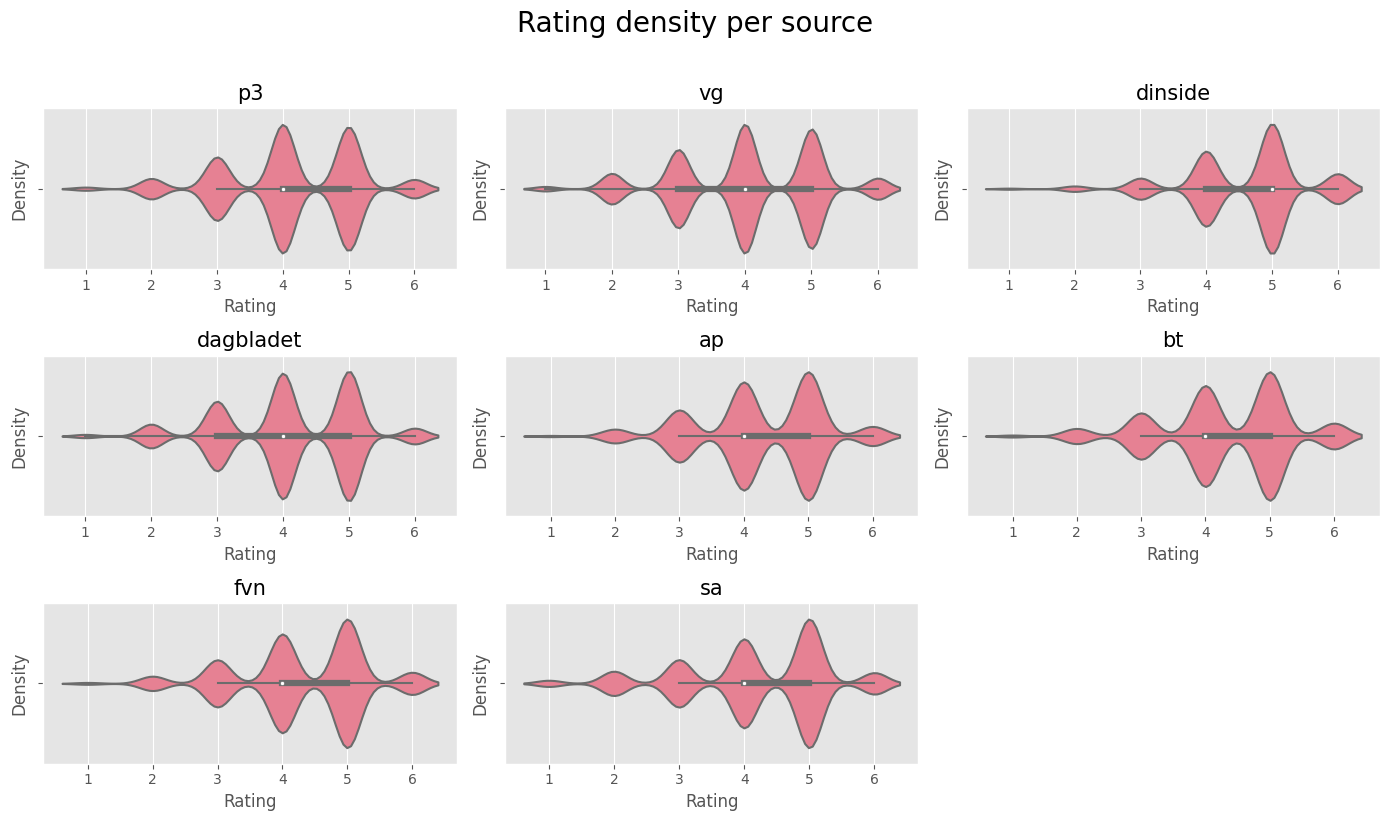

In [13]:
plt.figure(1 , figsize = (14 , 8))
n = 0
for source in binary_ds['source'].unique():
    n += 1
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    sns.violinplot(x='rating', data=binary_ds.where(binary_ds['source'] == source), palette='husl')
    plt.title(source, fontsize=15)
    plt.xlabel('Rating', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
plt.suptitle('Rating density per source', fontsize=20, y=1.02)   
plt.tight_layout()
plt.show()

## Binary and Multiclass

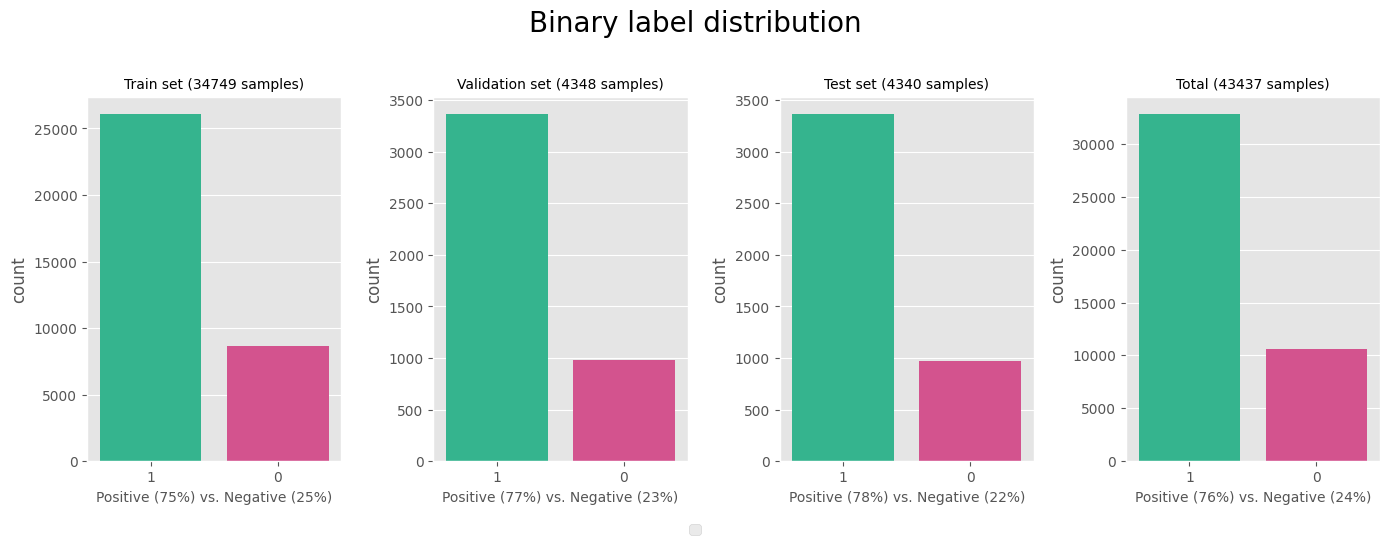

In [14]:
binary_train_ds = binary_ds[binary_ds.split == "train"]
binary_val_ds = binary_ds[binary_ds.split == "dev"]
binary_test_ds = binary_ds[binary_ds.split == "test"]

binary_train_total = binary_train_ds.shape[0]
binary_val_total = binary_val_ds.shape[0]
binary_test_total = binary_test_ds.shape[0]

train_positive_percent = round(binary_train_ds.label.value_counts(normalize=True)[BINARY_LABEL_TO_ID_MAPPING["positive"]] * 100)
dev_positive_percent = round(binary_val_ds.label.value_counts(normalize=True)[BINARY_LABEL_TO_ID_MAPPING["positive"]] * 100)
test_positive_percent = round(binary_test_ds.label.value_counts(normalize=True)[BINARY_LABEL_TO_ID_MAPPING["positive"]] * 100)
total_positive_percent = round(binary_ds.label.value_counts(normalize=True)[BINARY_LABEL_TO_ID_MAPPING["positive"]] * 100)

train_negative_percent = round(binary_train_ds.label.value_counts(normalize=True)[BINARY_LABEL_TO_ID_MAPPING["negative"]] * 100)
dev_negative_percent = round(binary_val_ds.label.value_counts(normalize=True)[BINARY_LABEL_TO_ID_MAPPING["negative"]] * 100)
test_negative_percent = round(binary_test_ds.label.value_counts(normalize=True)[BINARY_LABEL_TO_ID_MAPPING["negative"]] * 100)
total_negative_percent = round(binary_ds.label.value_counts(normalize=True)[BINARY_LABEL_TO_ID_MAPPING["negative"]] * 100)


fig, ax = plt.subplots(1, 4, figsize=(14, 5))

sns.countplot(x="label", data=binary_train_ds, ax=ax[0], palette=BINARY_PALETTE, order=[1, 0])
ax[0].set_title(f"Train set ({binary_train_total} samples)", fontsize=10)
ax[0].set_xlabel(f"Positive ({train_positive_percent}%) vs. Negative ({train_negative_percent}%)", fontsize=10)

sns.countplot(x="label", data=binary_val_ds, ax=ax[1], palette=BINARY_PALETTE, order=[1, 0])
ax[1].set_title(f"Validation set ({binary_val_total} samples)", fontsize=10)
ax[1].set_xlabel(f"Positive ({dev_positive_percent}%) vs. Negative ({dev_negative_percent}%)", fontsize=10)

sns.countplot(x="label", data=binary_test_ds, ax=ax[2], palette=BINARY_PALETTE, order=[1, 0])
ax[2].set_title(f"Test set ({binary_test_total} samples)", fontsize=10)
ax[2].set_xlabel(f"Positive ({test_positive_percent}%) vs. Negative ({test_negative_percent}%)", fontsize=10)

sns.countplot(x="label", data=binary_ds, ax=ax[3], palette=BINARY_PALETTE, order=[1, 0])
ax[3].set_title(f"Total ({binary_train_total + binary_val_total + binary_test_total} samples)", fontsize=10)
ax[3].set_xlabel(f"Positive ({total_positive_percent}%) vs. Negative ({total_negative_percent}%)", fontsize=10)

handles, labels = ax[0].get_legend_handles_labels()
labels = [BINARY_ID_TO_LABEL_MAPPING[int(label)] for label in labels]
fig.legend(handles[::-1], labels[::-1], loc='center', bbox_to_anchor=(0.5, -0.02), fancybox=True, ncol=2)

plt.suptitle('Binary label distribution', fontsize=20, y=1.02)   
plt.tight_layout()
plt.show()

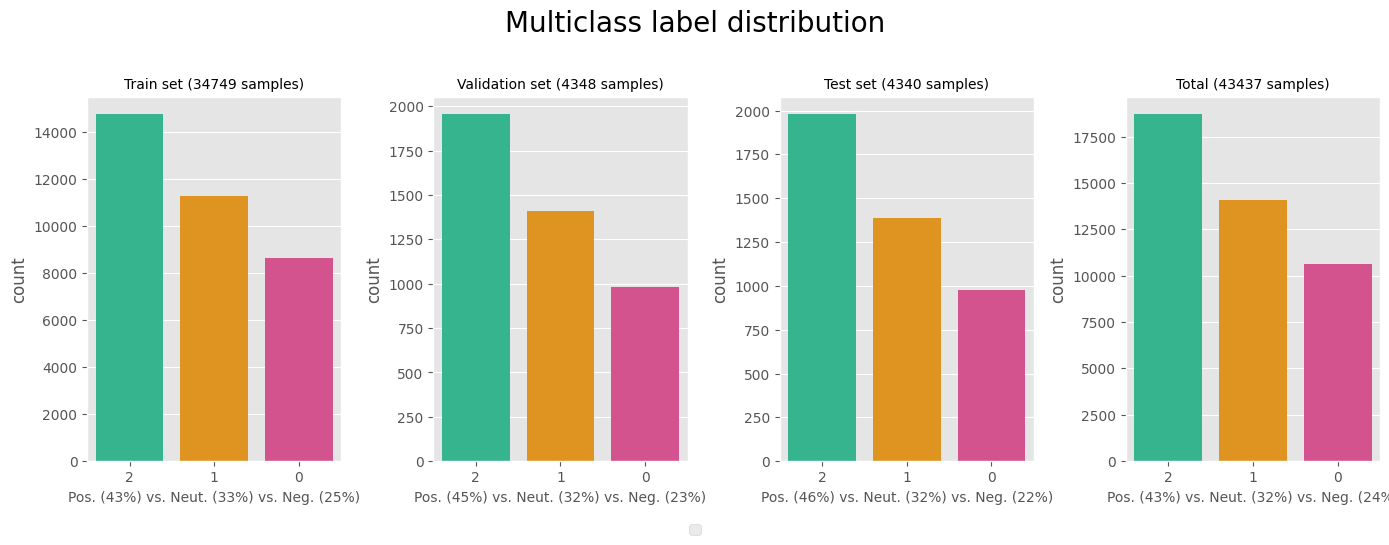

In [15]:
multiclass_train_ds = multiclass_ds[multiclass_ds.split == "train"]
multiclass_val_ds = multiclass_ds[multiclass_ds.split == "dev"]
multiclass_test_ds = multiclass_ds[multiclass_ds.split == "test"]

multiclass_train_total = multiclass_train_ds.shape[0]
multiclass_val_total = multiclass_val_ds.shape[0]
multiclass_test_total = multiclass_test_ds.shape[0]

train_positive_percent = round(multiclass_train_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["positive"]] * 100)
dev_positive_percent = round(multiclass_val_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["positive"]] * 100)
test_positive_percent = round(multiclass_test_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["positive"]] * 100)
total_positive_percent = round(multiclass_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["positive"]] * 100)

train_neutral_percent = round(multiclass_train_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["neutral"]] * 100)
dev_neutral_percent = round(multiclass_val_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["neutral"]] * 100)
test_neutral_percent = round(multiclass_test_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["neutral"]] * 100)
total_neutral_percent = round(multiclass_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["neutral"]] * 100)

train_negative_percent = round(multiclass_train_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["negative"]] * 100)
dev_negative_percent = round(multiclass_val_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["negative"]] * 100)
test_negative_percent = round(multiclass_test_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["negative"]] * 100)
total_negative_percent = round(multiclass_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["negative"]] * 100)


fig, ax = plt.subplots(1, 4, figsize=(14, 5))

sns.countplot(x="label", data=multiclass_train_ds, ax=ax[0], palette=MULTICLASS_PALETTE, order=[2, 1, 0])
ax[0].set_title(f"Train set ({multiclass_train_total} samples)", fontsize=10)
ax[0].set_xlabel(f"Pos. ({train_positive_percent}%) vs. Neut. ({train_neutral_percent}%) vs. Neg. ({train_negative_percent}%)", fontsize=10)

sns.countplot(x="label", data=multiclass_val_ds, ax=ax[1], palette=MULTICLASS_PALETTE, order=[2, 1, 0])
ax[1].set_title(f"Validation set ({multiclass_val_total} samples)", fontsize=10)
ax[1].set_xlabel(f"Pos. ({dev_positive_percent}%) vs. Neut. ({dev_neutral_percent}%) vs. Neg. ({dev_negative_percent}%)", fontsize=10)

sns.countplot(x="label", data=multiclass_test_ds, ax=ax[2], palette=MULTICLASS_PALETTE, order=[2, 1, 0])
ax[2].set_title(f"Test set ({multiclass_test_total} samples)", fontsize=10)
ax[2].set_xlabel(f"Pos. ({test_positive_percent}%) vs. Neut. ({test_neutral_percent}%) vs. Neg. ({test_negative_percent}%)", fontsize=10)

sns.countplot(x="label", data=multiclass_ds, ax=ax[3], palette=MULTICLASS_PALETTE, order=[2, 1, 0])
ax[3].set_title(f"Total ({multiclass_train_total + multiclass_val_total + multiclass_test_total} samples)", fontsize=10)
ax[3].set_xlabel(f"Pos. ({total_positive_percent}%) vs. Neut. ({total_neutral_percent}%) vs. Neg. ({total_negative_percent}%)", fontsize=10)

handles, labels = ax[0].get_legend_handles_labels()
labels = [MULTICLASS_ID_TO_LABEL_MAPPING[int(label)] for label in labels]
fig.legend(handles[::-1], labels[::-1], loc='center', bbox_to_anchor=(0.5, -0.02), fancybox=True, ncol=3)

plt.suptitle('Multiclass label distribution', fontsize=20, y=1.02)   
plt.tight_layout()
plt.show()

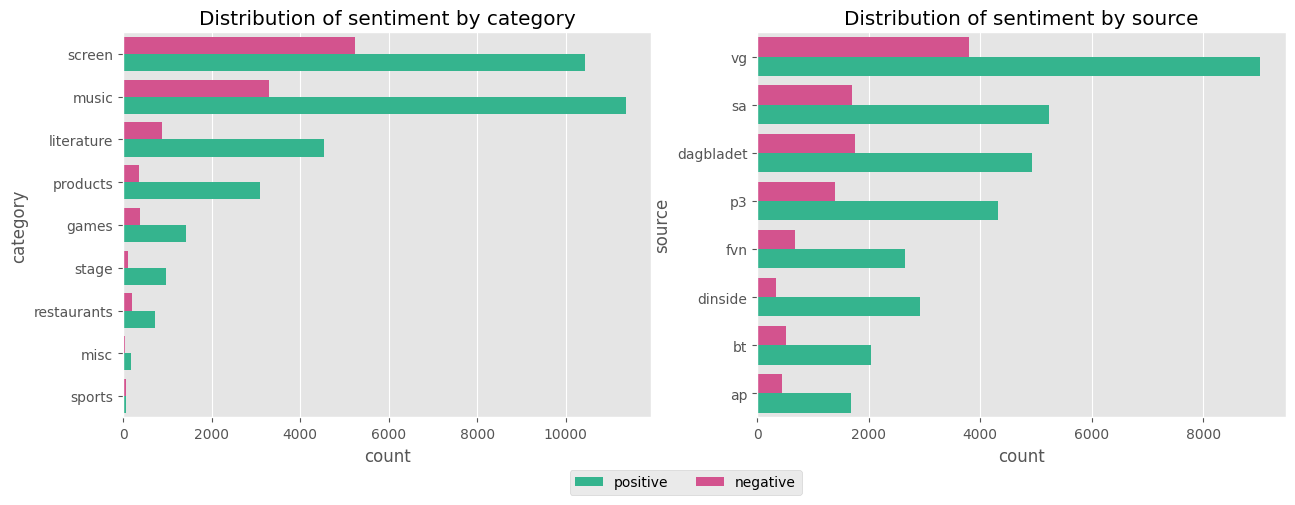

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(y="category", data=binary_ds, ax=ax[0], hue="label", palette=BINARY_PALETTE, order=binary_ds.category.value_counts().index)
ax[0].set_title("Distribution of sentiment by category")
ax[0].get_legend().remove()

sns.countplot(y="source", data=binary_ds, ax=ax[1], hue="label", palette=BINARY_PALETTE, order=binary_ds.source.value_counts().index)
ax[1].set_title("Distribution of sentiment by source")
ax[1].get_legend().remove()

handles, labels = ax[0].get_legend_handles_labels()
labels = [BINARY_ID_TO_LABEL_MAPPING[int(label)] for label in labels]
fig.legend(handles[::-1], labels[::-1], loc='center', bbox_to_anchor=(0.5, -0.02), fancybox=True, ncol=2)

plt.show()

# Review sentiment over time <a class="anchor" id="sentiment-time"></a>

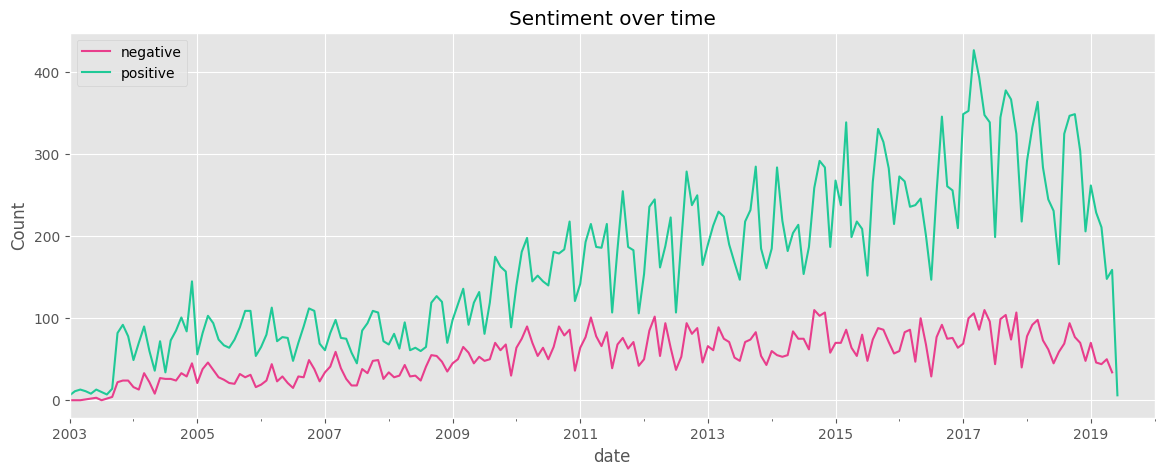

In [17]:
temp_df = binary_ds.copy()

temp_df['date'] = pd.to_datetime(temp_df['date'])
monthly_counts = temp_df.groupby('label').resample('ME', on='date').size()
monthly_counts = monthly_counts.reset_index(name='count')
monthly_counts['label'] = monthly_counts['label'].map(BINARY_ID_TO_LABEL_MAPPING)
pivot_df = monthly_counts.pivot(index='date', columns='label', values='count')

pivot_df.plot(kind='line', title='Sentiment over time', color=[NEGATIVE_COLOR, POSITIVE_COLOR], figsize=(14, 5))

plt.ylabel('Count')
plt.legend(loc='upper left')
plt.xlim([date(2003, 1, 1), date(2020, 1, 1)])
plt.show()

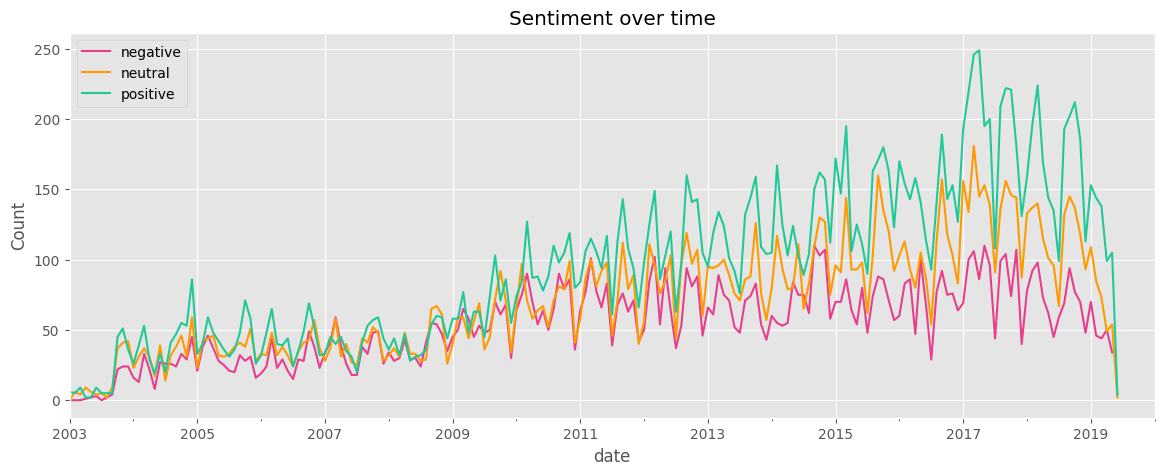

In [18]:
temp_df = multiclass_ds.copy()

temp_df['date'] = pd.to_datetime(temp_df['date'])
monthly_counts = temp_df.groupby('label').resample('ME', on='date').size()
monthly_counts = monthly_counts.reset_index(name='count')
monthly_counts['label'] = monthly_counts['label'].map(MULTICLASS_ID_TO_LABEL_MAPPING)
pivot_df = monthly_counts.pivot(index='date', columns='label', values='count')

pivot_df.plot(kind='line', title='Sentiment over time', color=[NEGATIVE_COLOR, NEUTRAL_COLOR, POSITIVE_COLOR], figsize=(14, 5))

plt.ylabel('Count')
plt.legend(loc='upper left')
plt.xlim([date(2003, 1, 1), date(2020, 1, 1)])
plt.show()

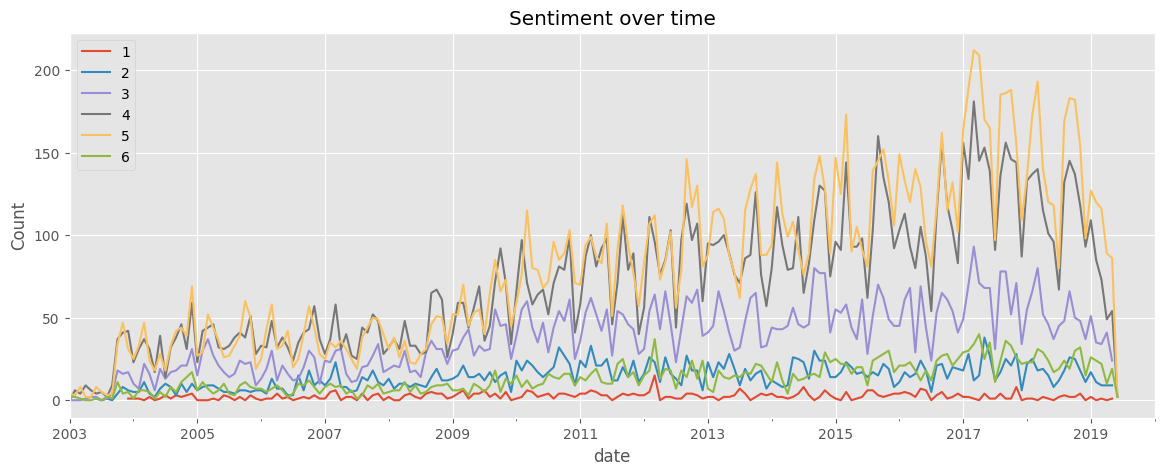

In [19]:
temp_df = multiclass_ds.copy()

temp_df['date'] = pd.to_datetime(temp_df['date'])
monthly_counts = temp_df.groupby('rating').resample('ME', on='date').size()
monthly_counts = monthly_counts.reset_index(name='count')
pivot_df = monthly_counts.pivot(index='date', columns='rating', values='count')

pivot_df.plot(kind='line', title='Sentiment over time', figsize=(14, 5))

plt.ylabel('Count')
plt.legend(loc='upper left')
plt.xlim([date(2003, 1, 1), date(2020, 1, 1)])
plt.show()

# n-gram analysis <a class="anchor" id="ngrams"></a>

In [20]:
class NoReCDataPreprocessor:
    @staticmethod
    def convert_to_lowercase(dataframe: pd.DataFrame) -> pd.DataFrame:
        tqdm.pandas(desc="Converting to lowercase")
        dataframe.loc[:, "text"] = dataframe["text"].progress_apply(
            lambda x: x.lower()
        )
        return dataframe

    @staticmethod
    def remove_punctuation(dataframe: pd.DataFrame) -> pd.DataFrame:
        def clean(text):
            text = text.replace("\n", " ")
            text = re.sub(r'[^a-zæøå]+', ' ', text)
            text = re.sub(r'\s+', ' ', text)
            return text

        tqdm.pandas(desc="Removing punctuation")
        dataframe.loc[:, "text"] = dataframe["text"].progress_apply(lambda x: clean(x))
        
        return dataframe

    @staticmethod
    def load_stopwords() -> List[str]:
        path = "/kaggle/input/norwegian-stopwords/stopwords.json"
        with open(path, encoding="utf-8") as file:
            stopwords = json.load(file)
            
        return stopwords

    def remove_stopwords(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        stopwords = self.load_stopwords()

        tqdm.pandas(desc="Removing stopwords")
        dataframe.loc[:, "text"] = dataframe["text"].progress_apply(
            lambda x: " ".join(
                [word for word in x.split() if word not in stopwords]
            )
        )
        return dataframe

    def sanitize(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        dataframe = self.convert_to_lowercase(dataframe)
        dataframe = self.remove_punctuation(dataframe)
        dataframe = self.remove_stopwords(dataframe)
        return dataframe[["text", "label"]]

In [21]:
def parse_ngrams(corpus: np.ndarray, n_gram: Tuple[int, int]) -> List[Tuple[str, int]]:
    vec = CountVectorizer(ngram_range=n_gram).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in tqdm(vec.vocabulary_.items(), desc=f"Processing {n_gram}-grams")]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq

cleaned_binary_ds = NoReCDataPreprocessor().sanitize(binary_ds)
positive_review_corpus = cleaned_binary_ds[cleaned_binary_ds.label == 1].text.values
negative_review_corpus = cleaned_binary_ds[cleaned_binary_ds.label == 0].text.values

positive_words = parse_ngrams(positive_review_corpus, (1, 1))
positive_bigrams = parse_ngrams(positive_review_corpus, (2, 2))
positive_trigrams = parse_ngrams(positive_review_corpus, (3, 3))

negative_words = parse_ngrams(negative_review_corpus, (1, 1))
negative_bigrams = parse_ngrams(negative_review_corpus, (2, 2))
negative_trigrams = parse_ngrams(negative_review_corpus, (3, 3))

Processing (3, 3)-grams: 100%|██████████| 1863124/1863124 [00:04<00:00, 423236.05it/s]


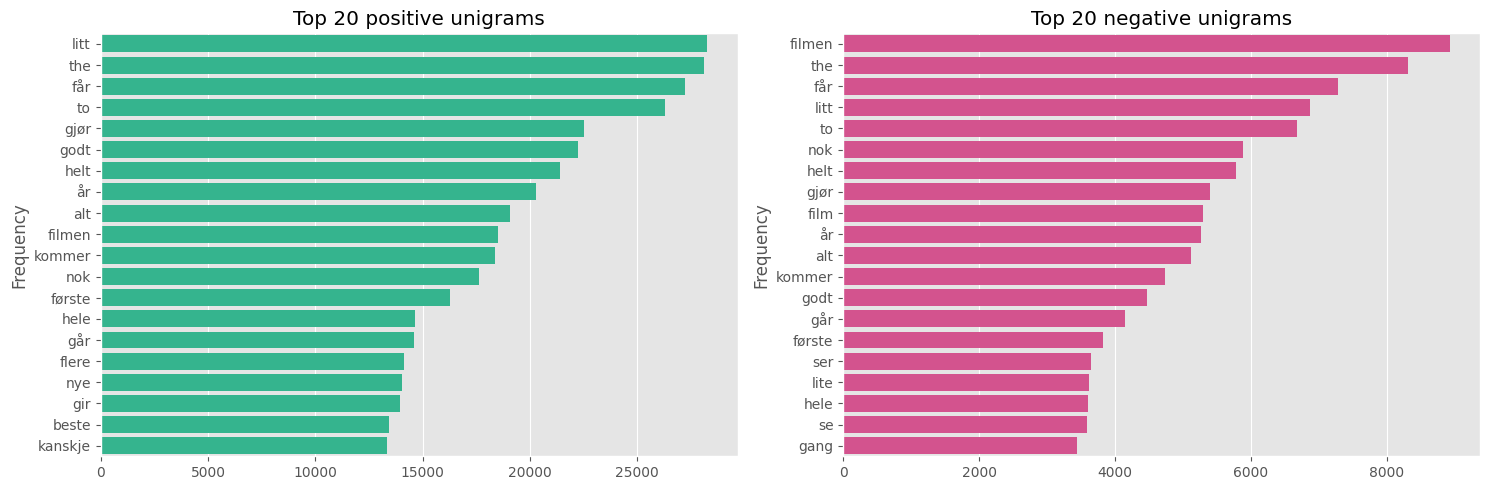

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(y=[item[0] for item in positive_words[:20]], x=[item[1] for item in positive_words[:20]], ax=ax[0], color=POSITIVE_COLOR)
ax[0].set_title("Top 20 positive unigrams")
ax[0].set_ylabel("Frequency")

sns.barplot(y=[item[0] for item in negative_words[:20]], x=[item[1] for item in negative_words[:20]], ax=ax[1], color=NEGATIVE_COLOR)
ax[1].set_title("Top 20 negative unigrams")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

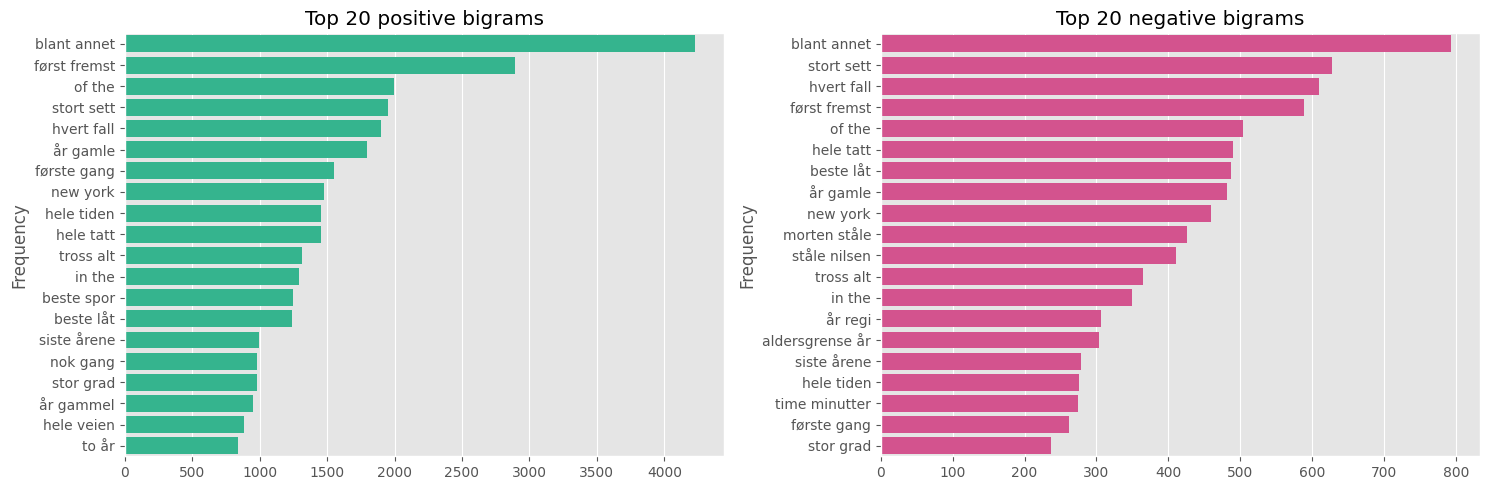

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(y=[item[0] for item in positive_bigrams[:20]], x=[item[1] for item in positive_bigrams[:20]], ax=ax[0], color=POSITIVE_COLOR)
ax[0].set_title("Top 20 positive bigrams")
ax[0].set_ylabel("Frequency")

sns.barplot(y=[item[0] for item in negative_bigrams[:20]], x=[item[1] for item in negative_bigrams[:20]], ax=ax[1], color=NEGATIVE_COLOR)
ax[1].set_title("Top 20 negative bigrams")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

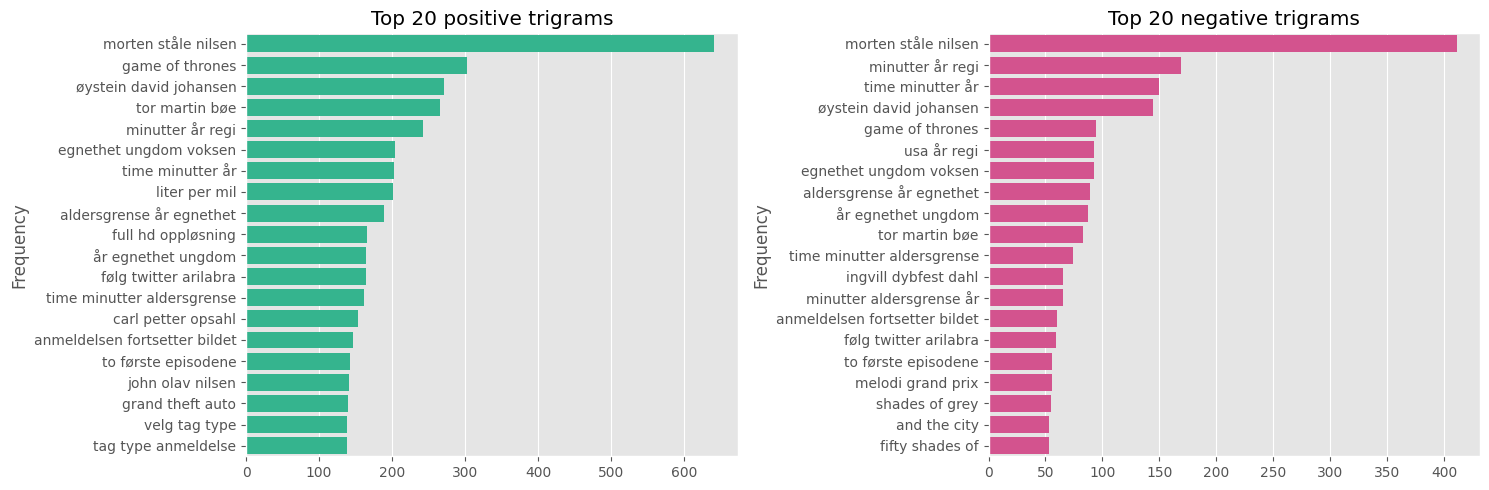

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(y=[item[0] for item in positive_trigrams[:20]], x=[item[1] for item in positive_trigrams[:20]], ax=ax[0], color=POSITIVE_COLOR)
ax[0].set_title("Top 20 positive trigrams")
ax[0].set_ylabel("Frequency")

sns.barplot(y=[item[0] for item in negative_trigrams[:20]], x=[item[1] for item in negative_trigrams[:20]], ax=ax[1], color=NEGATIVE_COLOR)
ax[1].set_title("Top 20 negative trigrams")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()